In [15]:
import os

if not os.path.exists("/content/BraTS2020_TrainingData") or not os.path.exists("/content/BraTS2020_ValidationData"):
  !unzip "/content/drive/MyDrive/Individual Project Final/brats_dataset.zip" > /dev/null

# if not os.path.exists("/content/models"):
#   !unzip "/content/drive/MyDrive/Individual Project Final/models.zip" > /dev/null

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, ReLU, Concatenate, Conv2DTranspose
import tensorflow.keras.backend as K
import re
from tensorflow.keras.models import load_model
import nibabel as nib
from tensorflow.keras.utils import Sequence
import cv2
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


VOLUME_SLICES = 100
VOLUME_START_AT = 22
IMG_SIZE = 128
BATCH_SIZE = 7

SEGMENT_CLASSES = {
    0 : 'NOT tumor', # include background
    1 : 'NECROTIC and NON-ENHANCING tumor core',
    2 : 'Peritumoral EDEMA',
    3 : 'GD-ENHANCING tumor', # labelled as 4 in dataset - we change to 3
}
NUM_CLASSES = len(SEGMENT_CLASSES)
MODALITIES = ['flair', 't1ce']
IMG_CHANNELS = len(MODALITIES)


In [17]:
#@title Create U-Net model

def create_unet(inputs, loss="categorical_crossentropy", num_filters=32, num_classes=NUM_CLASSES, kernel_initializer='he_normal', dropout_rate=0.2, metrics=['accuracy']):
    def encode_conv(inputs, filters):
        conv = Conv2D(filters, (3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(inputs)
        conv = BatchNormalization()(conv)  # Add batch normalization layer
        conv = Dropout(dropout_rate)(conv)
        conv = Conv2D(filters, (3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(conv)
        conv = BatchNormalization()(conv)  # Add batch normalization layer
        pool = MaxPooling2D(pool_size=(2, 2))(conv)
        return conv,pool

    def bottleneck_conv(inputs, filters):
        conv = Conv2D(filters, (3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(inputs)
        conv = BatchNormalization()(conv)  # Add batch normalization layer
        conv = Dropout(dropout_rate)(conv)
        conv = Conv2D(filters, (3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(conv)
        conv = BatchNormalization()(conv)  # Add batch normalization layer
        return conv

    def decode_conv(inputs, skip_connection, filters, concat_axis=-1):
        up = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
        up = Concatenate(axis=concat_axis)([up, skip_connection])
        conv = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(up)
        conv = BatchNormalization()(conv)  # Add batch normalization layer
        conv = Dropout(dropout_rate)(conv)
        conv = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(conv)
        conv = BatchNormalization()(conv)  # Add batch normalization layer
        return conv

    conv1, pool1 = encode_conv(inputs, num_filters)
    conv2, pool2 = encode_conv(pool1, num_filters*2)
    conv3, pool3 = encode_conv(pool2, num_filters*4)
    conv4, pool4 = encode_conv(pool3, num_filters*8)
    conv5 = bottleneck_conv(pool4, num_filters*16)
    up6 = decode_conv(conv5, conv4, num_filters*8)
    up7 = decode_conv(up6, conv3, num_filters*4)
    up8 = decode_conv(up7, conv2, num_filters*2)
    up9 = decode_conv(up8, conv1, num_filters, concat_axis=3)

    outputs = Conv2D(num_classes, (1,1), activation='sigmoid')(up9)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss=loss, optimizer=Adam(learning_rate=1e-3), metrics = metrics)

    return model

In [36]:
#@title Custom metrics

def binary_cross_entropy_per_channel(y_true, y_pred):
    # Define class weights
    class_weights = np.array([1.0, 10.0, 10.0, 10.0])
    class_weights /= np.sum(class_weights)
    
    # Compute binary cross-entropy loss for each channel separately, with class weights
    loss = 0.0
    channels = y_pred.shape[-1]
    for i in range(channels):
        weighted_loss = class_weights[i] * tf.losses.binary_crossentropy(y_true[..., i], y_pred[..., i])
        loss += weighted_loss
    return loss

# - Specificity
def specificity(y_true, y_pred):
    # specificity = TN / ( TN + FP )
    # Get sum of intersection of predicted negatives with ground truth negatives for true negatives (TN)
    true_negatives = K.sum((1-y_true[...,1:]) * (1-K.round(y_pred[...,1:])))
    # Get sum of ground truth negatives for actual negatives (equal to TN + FP)
    actual_negatives = K.sum(1-y_true[...,1:])
    return true_negatives / (actual_negatives + K.epsilon())

# - Sensitivity
def sensitivity(y_true, y_pred):
    # sensitivity = TP / ( TP + FN )
    # Get sum of intersection of predicted positives with ground truth positives for true positives (TP)
    true_positives = K.sum(y_true[...,1:] * K.round(y_pred[...,1:]))
    # Get sum of ground truth positives for actual positives (equal to TP + FN)
    actual_positives = K.sum(y_true[...,1:])
    return true_positives / (actual_positives + K.epsilon())

# - Dice coefficient index (*Dci*)
def _dice_loss_for_label(y_true, y_pred, label, smooth=1e-7):
    # Flatten the ground truth and predicted masks
    y_true_f = K.flatten(y_true[...,label])
    y_pred_f = K.flatten(y_pred[...,label])

    # Compute the intersection and union
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)

    # Compute the Dice coefficient
    dice_coef = (2.0 * intersection + smooth) / (union + smooth)

    # Compute the Dice loss as 1 - Dice coefficient
    dice_loss = 1.0 - dice_coef

    return dice_loss

def dice_loss(y_true, y_pred, smooth=1e-6):
    # Define class weights
    class_weights = np.array([1.0, 10.0, 10.0, 10.0])  # Adjust the weights as needed
    class_weights /= np.sum(class_weights)

    dice = 0
    for i in range(NUM_CLASSES):
        dice += class_weights[i] *  _dice_loss_for_label(y_true, y_pred, i, smooth)
    return dice

 
def dice_loss_necrotic(y_true, y_pred, smooth=1e-6):
    return _dice_loss_for_label(y_true, y_pred, 1, smooth)

def dice_loss_edema(y_true, y_pred, smooth=1e-6):
    return _dice_loss_for_label(y_true, y_pred, 2, smooth)


def dice_loss_enhancing(y_true, y_pred, smooth=1e-6):
    return _dice_loss_for_label(y_true, y_pred, 3, smooth)

def combined_loss(y_true, y_pred, alpha=0.5, smooth=1e-5):
    """
    Combined loss function that combines binary cross entropy and Dice loss.
    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :param alpha: Weight of binary cross entropy in the loss.
    :param smooth: Smoothing term to avoid division by zero.
    :return: combined loss.
    """
    # Calculate binary cross entropy
    bce = binary_cross_entropy_per_channel(y_true, y_pred)

    # Calculate Dice loss
    dl = dice_loss(y_true, y_pred)

    # Calculate combined loss
    combined = alpha * bce + (1-alpha) * dl

    return combined

In [19]:
#@title Train-test split with sample IDs
# Define the directories where the scans are located
TRAIN_DATASET_PATH = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/content/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

train_dirs = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
validation_dirs = [f.path for f in os.scandir(VALIDATION_DATASET_PATH) if f.is_dir()]

# # remove file BraTS20_Training_355, which has ill formatted name for for seg.nii file
# validation_dirs.remove(VALIDATION_DATASET_PATH+'BraTS20_Validation_006')
# validation_dirs.remove(VALIDATION_DATASET_PATH+'BraTS20_Validation_050')
# train_dirs.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')

import re

def get_id_from_path(path):
  m = re.search('BraTS20_(Training|Validation)_(\d+)', path)
  return m.group(2)


def get_ids_to_remove(directories, look_for):
  delete_ids = []
  for directory in directories:
    for _,__,files in os.walk(directory):
      # print(files)
      # print()
      delete = False
      for word in look_for:
        if not any(word in x for x in files):
            delete = True
            break
      if delete:

        id = get_id_from_path(directory)
        delete_ids.append(id)
  return delete_ids

# Get IDs for volumes and remove volume if doesn't contain all necessary files
delete_ids = get_ids_to_remove(train_dirs, ['t1ce', 'flair', 'seg'])
train_ids = list(set([get_id_from_path(p) for p in train_dirs]))
for id in delete_ids:
  train_ids.remove(id)

delete_ids = get_ids_to_remove(validation_dirs, ['t1ce', 'flair'])
validation_ids = list(set([get_id_from_path(p) for p in validation_dirs]))
for id in delete_ids:
  validation_ids.remove(id)

from sklearn.model_selection import train_test_split
train_ids, test_ids = train_test_split(train_ids,test_size=0.2)

# print(train_ids)
print(len(train_ids))
print(len(test_ids))
print(len(validation_ids))

294
74
125


In [20]:
def frac_tumours(id):
  epsilon = 1e-6
  file_path_prefix = "BraTS20_Training"
  file_path = os.path.join(TRAIN_DATASET_PATH, 
                                         '{}_{}'.format(file_path_prefix, id), 
                                         '{}_{}'.format(file_path_prefix, id) + "_seg.nii")
  if os.path.exists(file_path):
    mask = nib.load(file_path).get_fdata()
    # Count the number of occurrences of each label
    labels, counts = np.unique(mask, return_counts=True)
    frac = 0
    if len(labels) > 1:
      bg_pixels = counts[0]
      if (labels[0] != 0):
        print('WARNING')
      tumour_pixels = counts[1:].sum()
      frac = (tumour_pixels + epsilon) / ((tumour_pixels + bg_pixels) + epsilon)
    return frac
  
oversample_ids = [id for id in train_ids if (frac_tumours(id) * 100) > 2]
print(oversample_ids)
print(len(oversample_ids))

['183', '001', '252', '289', '149', '316', '284', '261', '291', '235', '327', '166', '369', '026', '212', '144', '225', '308', '333', '318', '037', '075', '138', '009', '273', '272', '306', '152', '290', '328']
30


In [21]:
if len(oversample_ids) > 0:
  for i in range(10):
    train_ids += oversample_ids
print(len(train_ids))


594


In [22]:
print(len(train_ids))

594


In [23]:
def perform_data_augmentation(images, mask):
    """
    Apply data augmentation techniques to the input images and mask.
    """

    # Randomly select an augmentation technique
    augmentation_type = np.random.choice(['rotate', 'flip_horizontal', 'flip_vertical', 'adjust_brightness', 'zoom'])
    # Check if mask contains tumor classes
    if np.max(mask) > 0:
        augmented_images = []
        # Apply augmentation only to slices containing tumor classes
        if augmentation_type == 'rotate':
            # Apply rotation
            angle = np.random.uniform(-15, 15)
            for image in images:
              augmented_images.append(rotate_image(image, angle))
            mask = rotate_image(mask, angle)

        elif augmentation_type == 'flip_horizontal':
            # Apply horizontal flip
            for image in images:
              augmented_images.append(cv2.flip(image, 1))
            mask = cv2.flip(mask, 1)
        elif augmentation_type == 'flip_vertical':
            # Apply vertical flip
            for image in images:
              augmented_images.append(cv2.flip(image, 0))
            mask = cv2.flip(mask, 0)
        elif augmentation_type == 'adjust_brightness':
            # Apply brightness adjustment
            brightness_factor = np.random.uniform(0.8, 1.2)
            for image in images:
              augmented_images.append(adjust_brightness(image, brightness_factor))
        elif augmentation_type == 'zoom':
            # Random zoom
            zoom_factor = np.random.uniform(0.9, 1.1)
            for image in images:
              augmented_images.append(zoom_image(image, zoom_factor))
            mask = zoom_image(mask, zoom_factor)
        
        return augmented_images, mask

    # Return original images and mask
    return images, mask


def rotate_image(image, angle):
    """
    Rotate the image by given angle.
    """
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(image, M, (cols, rows))

def zoom_image(image, factor):
    """
    Zoom the image by given factor.
    """
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 0, factor)
    return cv2.warpAffine(image, M, (cols, rows))

def adjust_brightness(image, factor):
    """
    Adjust the brightness of the image by given factor.
    """
    # Convert image to float32 for arithmetic operations
    image = image.astype(np.float32)

    # Adjust brightness of each channel separately
    for i in range(image.shape[-1]):
        image[..., i] = image[..., i] * factor

    # Clip pixel values to [0, 255]
    image = np.clip(image, 0, 255)

    # Convert image back to uint8
    image = image.astype(np.uint8)

    return image


In [24]:
#@title Data Generator
# https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c

# Use data generator as data cannot be loaded all at once into RAM
class DataGenerator(Sequence):
  'Generates data for Keras'
  def __init__(self, list_IDs, data_path, file_path_prefix, seed=-1, slice_interval=1, to_fit=True, batch_size=BATCH_SIZE, dim=(IMG_SIZE,IMG_SIZE), shuffle=True, augment=True):
      'Initialization'
      self.list_IDs = list_IDs
      self.data_path = data_path
      self.file_path_prefix = file_path_prefix
      self.slice_interval = slice_interval if slice_interval >=1 else 1
      self.to_fit = to_fit
      self.batch_size = batch_size
      self.dim = dim
      self.n_channels = IMG_CHANNELS
      self.shuffle = shuffle
      self.augment = augment
      self.slice_offset=0
      if seed >= 0:
          np.random.seed = seed
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.list_IDs) / self.batch_size))

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.list_IDs))
      if self.shuffle == True:
          np.random.shuffle(self.indexes)
      if self.slice_interval > 1:
          self.slice_offset = np.random.randint(0, self.slice_interval)


  def __getitem__(self, index):
      # Generate one batch of data

      # Generate indexes of the batch
      indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

      # Find list of IDs
      list_IDs_temp = [self.list_IDs[i] for i in indexes]

      return self._generate_data(list_IDs_temp)

  def _generate_data(self, list_IDs_temp):
      """Generates data containing batch_size images, and batch_size masks if to_fit
      :param list_IDs_temp: list of label ids to load
      :return: batch of images, and masks if to_fit
      """
      data = np.zeros((self.batch_size*VOLUME_SLICES//self.slice_interval, IMG_SIZE, IMG_SIZE, self.n_channels))
      labels = np.zeros((self.batch_size*VOLUME_SLICES//self.slice_interval, IMG_SIZE, IMG_SIZE, NUM_CLASSES))

      # Generate data
      for i, ID in enumerate(list_IDs_temp):
          scan_data = self._load_scan_data(ID)
          # include an offset so that distribution of slices is more randomized
          for j in range(VOLUME_SLICES//self.slice_interval - 1):
              modality_images = []
              for modality in MODALITIES:
                modality_images.append(scan_data[modality][:,:,j*self.slice_interval+self.slice_offset+VOLUME_START_AT])
              
              if (self.to_fit):
                masks = scan_data['seg'][:,:,j*self.slice_interval+self.slice_offset+VOLUME_START_AT]
                masks[masks==4] = 3
                if self.augment:
                    modality_images, masks = perform_data_augmentation(modality_images, masks)
                # segmentation classes
                masks = cv2.resize(masks, (IMG_SIZE, IMG_SIZE))
                for c in range(NUM_CLASSES):
                  labels[j + VOLUME_SLICES*i//self.slice_interval,:,:,c] = (masks == c).astype(int)
              
              for chan, modality in enumerate(MODALITIES):
                data[j + VOLUME_SLICES*i//self.slice_interval,:,:,chan] = cv2.resize(modality_images[chan], (IMG_SIZE, IMG_SIZE))

      data /= np.max(data)

      if self.to_fit:
        # Generate masks
        return data, labels
      else:
        return data

  def _load_scan_data(self, scan_id):
      file_path = lambda i: os.path.join(self.data_path, 
                                         '{}_{}'.format(self.file_path_prefix, i), 
                                         '{}_{}'.format(self.file_path_prefix, i))
      # Load the .nii files for this scan
      # modality_files = [file_path(scan_id) + '_{}.nii'.format(modality for modality in MODALITIES)]

      scan_data = dict()
      for modality in MODALITIES:
          modality_file = file_path(scan_id) + '_{}.nii'.format(modality)
          scan_data[modality] = nib.load(modality_file).get_fdata() if os.path.exists(modality_file) else None

      if self.to_fit:
        seg_file = file_path(scan_id) + '_seg.nii'
        scan_data['seg'] = nib.load(seg_file).get_fdata() if os.path.exists(seg_file) else None
      
      return scan_data


In [25]:
job_index = 0
num_jobs = 1
num_epochs = 3

In [26]:
callbacks = [
  # EarlyStopping(monitor='loss', min_delta=0, patience=2, verbose=1, mode='auto'),
  ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1),
]

In [5]:
K.clear_session()
for i in range(job_index, num_jobs):
  job_index = i

  start_epoch = job_index * num_epochs // num_jobs
  end_epoch = (job_index + 1) * num_epochs // num_jobs

  # Load the model from a file
  prev_model_filename = "/content/current/model_job{}".format(job_index - 1)
  model_filename = "/content/current/model_job{}".format(job_index)
  if start_epoch == 0:
      metrics = ['accuracy', sensitivity, specificity, binary_cross_entropy_per_channel, dice_loss, dice_loss_necrotic, dice_loss_edema, dice_loss_enhancing]
      inputs = Input((IMG_SIZE,IMG_SIZE,IMG_CHANNELS))
      model = create_unet(inputs, loss=combined_loss, metrics=metrics)
  else:
      model = load_model(prev_model_filename, custom_objects={
        "combined_loss": combined_loss,
        "dice_loss": dice_loss,
        "dice_loss_necrotic": dice_loss_necrotic,
        "dice_loss_edema": dice_loss_edema,
        "dice_loss_enhancing": dice_loss_enhancing, 
        "sensitivity": sensitivity,
        "specificity": specificity,
        "binary_cross_entropy_per_channel": binary_cross_entropy_per_channel
      })

  training_gen = DataGenerator(train_ids, TRAIN_DATASET_PATH, 'BraTS20_Training', slice_interval=5)
  test_gen = DataGenerator(test_ids, TRAIN_DATASET_PATH, 'BraTS20_Training')

  model.fit(training_gen, 
            epochs=end_epoch, 
            steps_per_epoch=len(train_ids)/BATCH_SIZE,
            initial_epoch=start_epoch, 
            callbacks=callbacks, 
            validation_data = test_gen)

  # Save the model to a file
  model.save(model_filename)

NameError: ignored

In [37]:
model = load_model("/content/drive/MyDrive/Individual Project Final/multilabel/models/model_job8", custom_objects={
        "combined_loss": combined_loss,
        "dice_loss": dice_loss,
        "dice_loss_necrotic": dice_loss_necrotic,
        "dice_loss_edema": dice_loss_edema,
        "dice_loss_enhancing": dice_loss_enhancing, 
        "sensitivity": sensitivity,
        "specificity": specificity,
	      "binary_cross_entropy_per_channel": binary_cross_entropy_per_channel
    })

training_gen = DataGenerator(train_ids, TRAIN_DATASET_PATH, 'BraTS20_Training', slice_interval=2)
test_gen = DataGenerator(test_ids, TRAIN_DATASET_PATH, 'BraTS20_Training')
X_test, y_test = test_gen.__getitem__(0)
model.evaluate(X_test, y_test, batch_size=7)

100/100 [==============================] - 69s 684ms/step - loss: 0.4059 - accuracy: 0.9858 - sensitivity: 0.2880 - specificity: 0.9972 - binary_cross_entropy_per_channel: 0.0378 - dice_loss: 0.7739 - dice_loss_necrotic: 0.8458 - dice_loss_edema: 0.7540 - dice_loss_enhancing: 0.7978


[0.4058711528778076,
 0.9857853651046753,
 0.28800132870674133,
 0.9971504211425781,
 0.03784769028425217,
 0.7738945484161377,
 0.8457565307617188,
 0.7540069818496704,
 0.7977502942085266]

In [ ]:
tf.keras.utils.plot_model(
    model,
    # to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [ ]:
model.summary()

4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

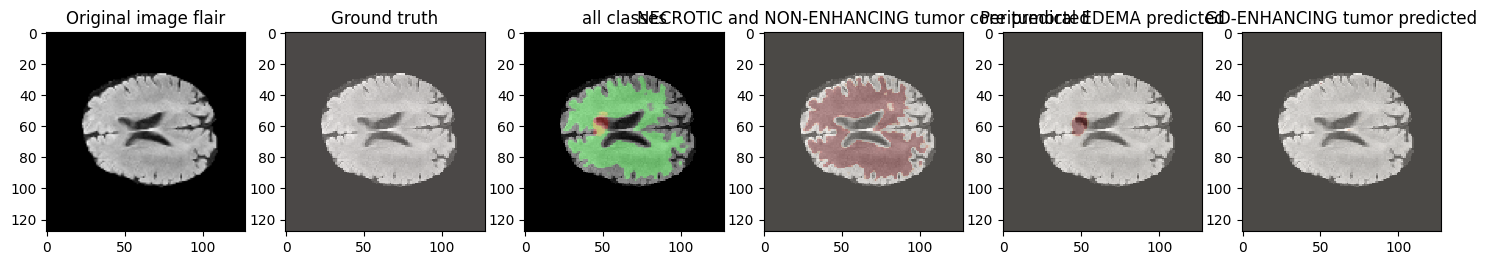

4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

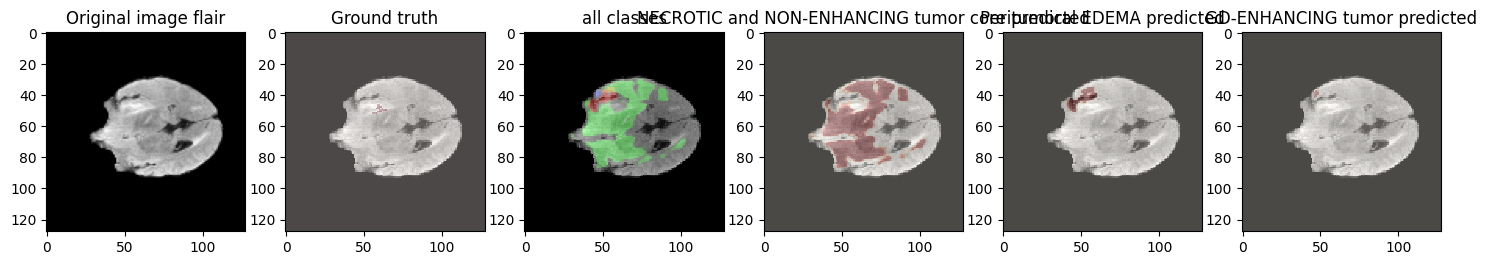

4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

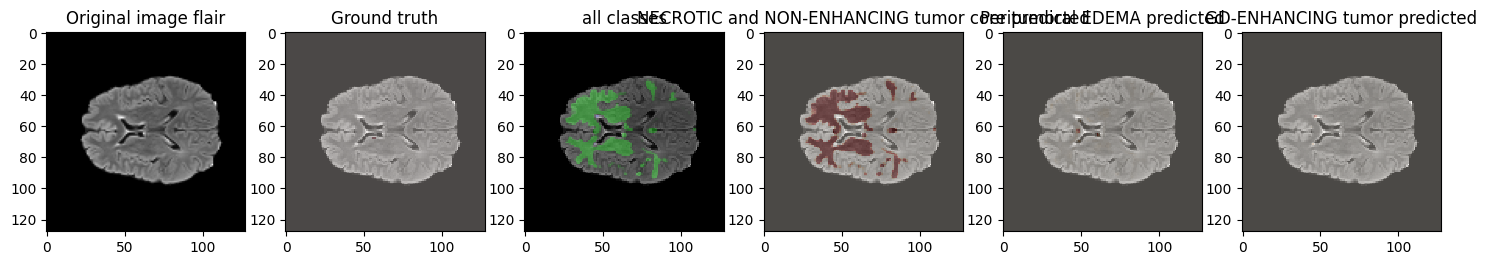

4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

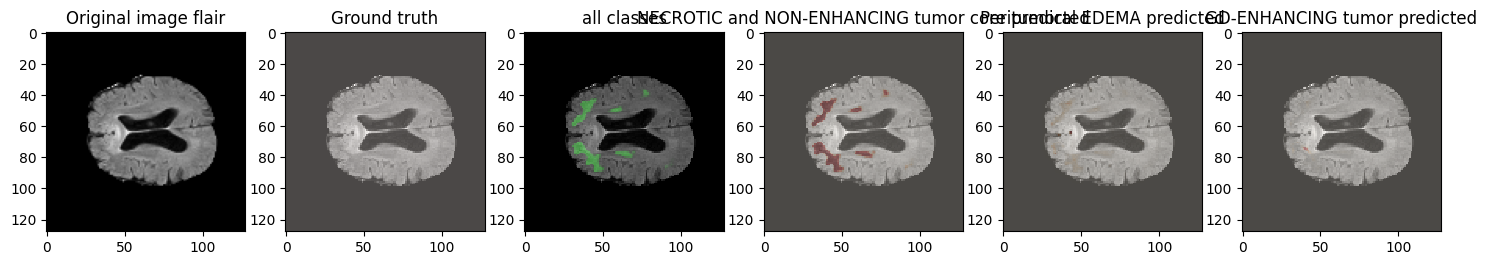

4/4 [==============================] - 7s 2s/step


<Figure size 1800x5000 with 0 Axes>

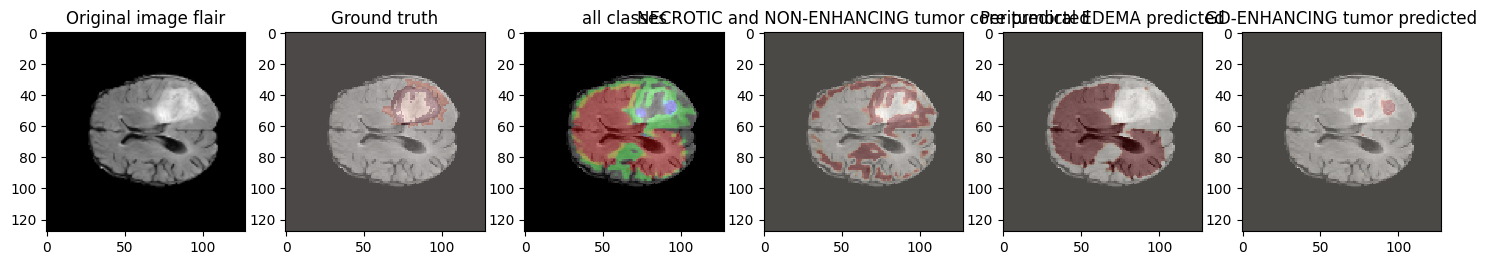

4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

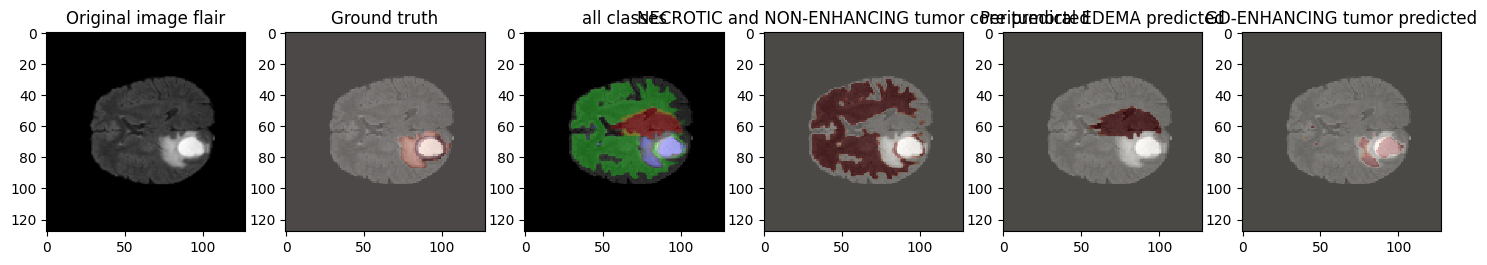

4/4 [==============================] - 8s 2s/step


<Figure size 1800x5000 with 0 Axes>

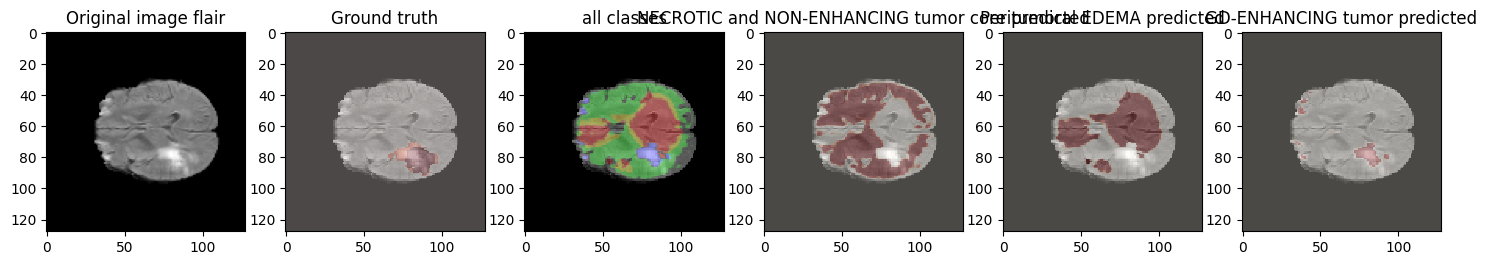

Evaluate on test data
 1/10 [==>...........................] - ETA: 9:38 - loss: 0.2559 - accuracy: 0.9799 - sensitivity: 0.0095 - specificity: 0.9846 - binary_cross_entropy_per_channel: 0.0482 - dice_loss: 0.4635 - dice_loss_necrotic: 0.5505 - dice_loss_edema: 0.5506 - dice_loss_enhancing: 0.3338

KeyboardInterrupt: ignored

In [35]:

#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, IMG_CHANNELS))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_gen)
print("test loss, test acc:", results)


In [ ]:
validation_gen = DataGenerator(validation_ids, VALIDATION_DATASET_PATH, 'BraTS20_Validation', to_fit=False, slice_interval=2)

results = model.predict(validation_gen)

 7/17 [===========>..................] - ETA: 4:13

KeyboardInterrupt: ignored

In [ ]:
print(results[0].shape)
totals = [0,0,0,0]
# print(y_train[0].shape)
for result in results:
  # totals = [0,0,0,0]
  for x in range(result.shape[0]):
    for y in range(result.shape[1]):
      for i in range(len(totals)):
        totals[i] += result[x,y,i]

# print(totals)
normalized_totals = totals / np.sum(totals)

print(normalized_totals)

NameError: ignored

In [ ]:
segmentation_maps = []
totals = [0,0,0,0]

# Use the model to make a prediction
for X_train, y_train in training_gen:

  for label in y_train:
    # Choose the class with the highest probability for each pixel
    label_class = np.argmax(label, axis=-1)
    for i in range(4):
      if np.any(label_class == i):
        totals[i] += 1

print(totals)


0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
0.027525152
[14700, 5329, 8675, 5338]


In [38]:
training_gen = DataGenerator(train_ids, TRAIN_DATASET_PATH, 'BraTS20_Training', slice_interval=2)
test_gen = DataGenerator(test_ids, TRAIN_DATASET_PATH, 'BraTS20_Training')
X_train, y_train = training_gen.__getitem__(0)
X_test, y_test = test_gen.__getitem__(0)
print(X_train.shape)
print(y_train.shape)
results = model.predict(X_test)

(350, 128, 128, 2)
(350, 128, 128, 4)
22/22 [==============================] - 57s 3s/step


In [39]:

def contains_tumour(label):
  c = np.argmax(label, axis=-1)
  return np.any(c == 1) and np.any(c==2) and np.any(c==3)
  # return np.max(label) > 0

def all_background(label):
  return np.max(label) == 0

tumour_gt = [i for i, label in enumerate(y_test) if contains_tumour(label)]
tumour_pred = [i for i, label in enumerate(results) if contains_tumour(label)]
bg_gt = [i for i, pred in enumerate(y_train) if all_background(pred)]
bg_pred = [i for i, pred in enumerate(results) if all_background(pred)]
print(len(results))
print(tumour_gt)
print(tumour_pred)
print(len(tumour_gt))
print(len(tumour_pred))

print(y_train.shape)
print(results.shape)
# print(y_train[...,2][137][0])
# print(results[...,2][137][0])

700
[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 168, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 282, 284, 288, 291, 292, 293, 297, 298, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 

In [40]:
i = 0
for X_train, y_train in training_gen:
  results = model.predict(X_train)
  tumour_pred = [i for i, pred in enumerate(results) if contains_tumour(pred)]
  if len(tumour_pred) > 1:
    print("tumour found at ")
    break
  i+=1


11/11 [==============================] - 26s 2s/step
tumour found at 


In [41]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=37969aa9b9cfc980e6e2ba6369d180fd01c2c22c703c6cd1089000a6983dce70
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

# print(X_train.shape)
nsamples, nx, ny, nc = X_train.shape
X_train_reshaped = X_train.reshape((nsamples,nx*ny*nc))

explainer = lime_image.LimeImageExplainer(random_state=42)

# # Define a predict function that takes reshaped data as input
def predict_fn(images):
    # print(images.shape)
    reverted_images = np.stack((images[...,0],images[...,1]), axis=-1)
    # print(reverted_images.shape)

    masks = model.predict(reverted_images)
    # masks = masks/np.max(masks)
    nsamples, nx, ny, nc = masks.shape
    return masks.reshape((nsamples,nx*ny*nc))


# print(X_train.shape)

# predict_fn(X_train[10])
# Get explanation for X_train[10]
sample = 146
image = X_test[sample]
converted_image = np.stack((image[...,0],image[...,1],image[...,0]), axis=-1) 
print(converted_image.shape)

explanation = explainer.explain_instance(
         converted_image,
         predict_fn,
         top_labels=NUM_CLASSES,
        #  hide_color=0,
         num_samples=100
)


(128, 128, 3)


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 1s 650ms/step


In [ ]:
# sample = 35
# image = X_test[sample]
ground_truth = y_test[sample]
prediction = results[sample]

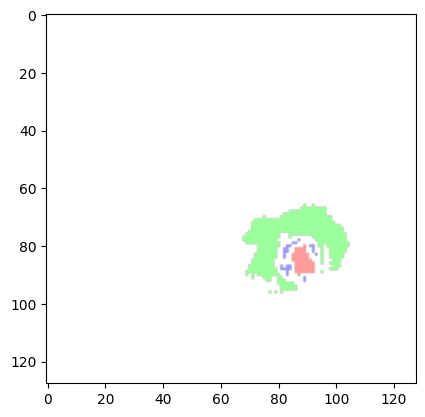

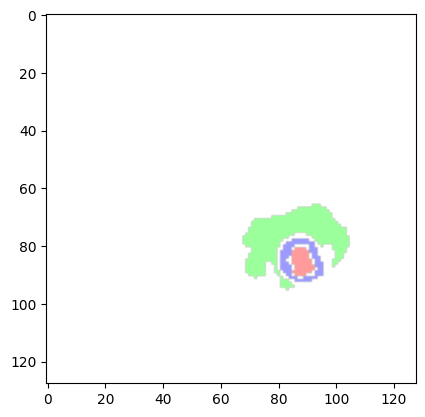

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

threshold = 0.8
# Create separate masks for each class in ground truth
gt_non_tumour = (ground_truth[..., 0])
gt_necrotic = (ground_truth[..., 1])
gt_edema = (ground_truth[..., 2])
gt_gd_enhancing = (ground_truth[..., 3])

# Create separate masks for each class in prediction
pred_non_tumour = (prediction[..., 0] >= threshold).astype(int)
pred_necrotic = (prediction[..., 1] >= threshold).astype(int)
pred_edema = (prediction[..., 2] >= threshold).astype(int)
pred_gd_enhancing = (prediction[..., 3] >= threshold).astype(int)

# Create a color map
colors = np.array([[0, 0, 0, 0], [255, 0, 0, 100], [0, 255, 0, 100], [0, 0, 255, 100]])

# Create the segment map for ground truth
gt_sm = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 4), dtype=np.uint8)
gt_sm[gt_non_tumour == 1] = colors[0]
gt_sm[gt_necrotic == 1] = colors[1]
gt_sm[gt_edema == 1] = colors[2]
gt_sm[gt_gd_enhancing == 1] = colors[3]

# Create the segment map for prediction
pred_sm = np.zeros((prediction.shape[0], prediction.shape[1], 4), dtype=np.uint8)
pred_sm[pred_non_tumour == 1] = colors[0]
pred_sm[pred_necrotic == 1] = colors[1]
pred_sm[pred_edema == 1] = colors[2]
pred_sm[pred_gd_enhancing == 1] = colors[3]

# Show the segment map for ground truth
plt.imshow(gt_sm)
plt.show()

# Show the segment map for prediction
plt.imshow(pred_sm)
plt.show()


(128, 128)
NOT tumor


<Figure size 1800x5000 with 0 Axes>

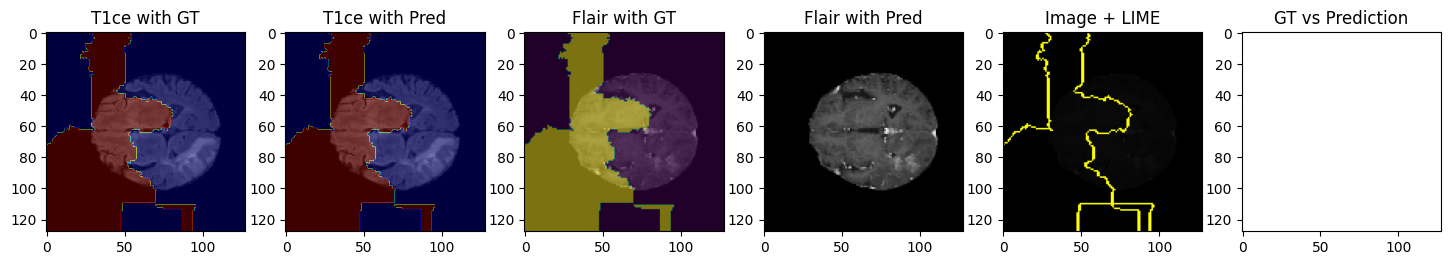

(128, 128)
NECROTIC and NON-ENHANCING tumor core


<Figure size 1800x5000 with 0 Axes>

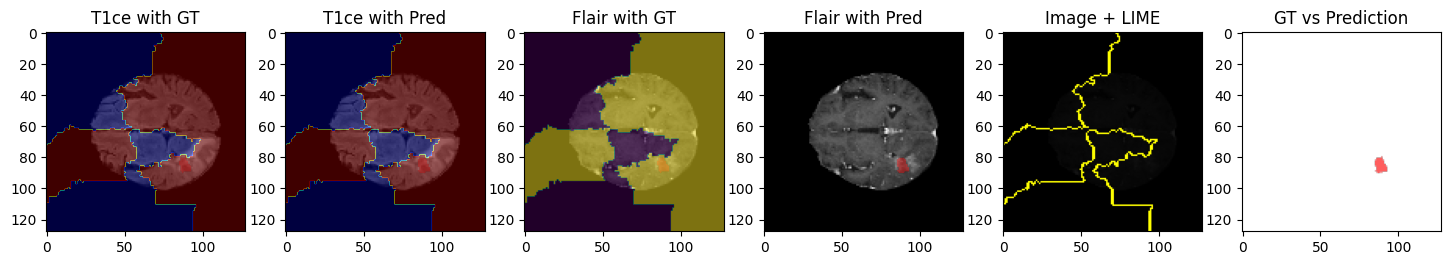

(128, 128)
Peritumoral EDEMA


<Figure size 1800x5000 with 0 Axes>

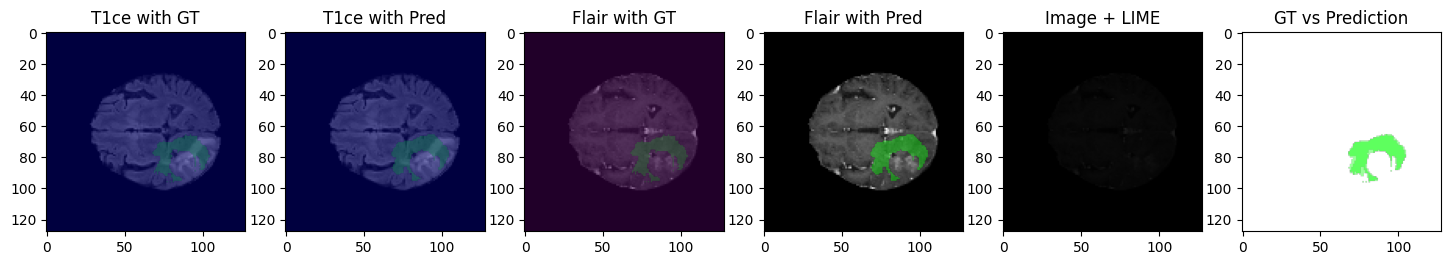

(128, 128)
GD-ENHANCING tumor


<Figure size 1800x5000 with 0 Axes>

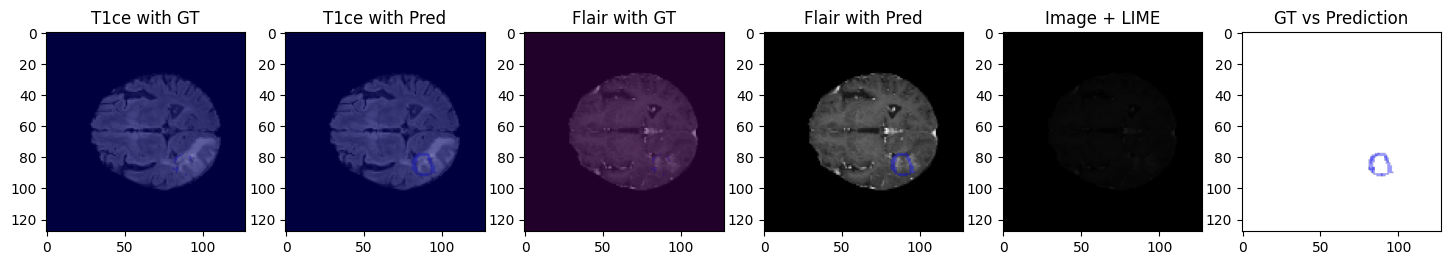

(128, 128)
WHOLE Tumour


<Figure size 1800x5000 with 0 Axes>

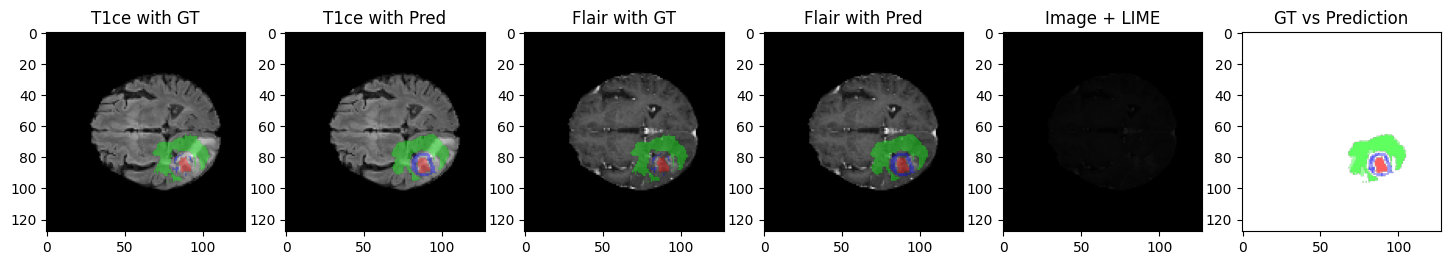

In [ ]:
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

gt_sm_whole = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 4), dtype=np.uint8)
pred_sm_whole = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 4), dtype=np.uint8)

for i in range(5):
  gt_sm = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 4), dtype=np.uint8)
  pred_sm = np.zeros((ground_truth.shape[0], ground_truth.shape[1], 4), dtype=np.uint8)
  if i < 4:
    gt = (ground_truth[..., i])
    gt_sm[gt == 1] = colors[i]
    gt_sm_whole[gt == 1] = colors[i]
    pred = (prediction[..., i])
    pred_sm[pred >= 0.5] = colors[i]
    pred_sm_whole[pred >= 0.5] = colors[i]

     # Get the image and mask from the explanation
    img, mask = explanation.get_image_and_mask(
            explanation.top_labels[i],
            positive_only=True,
            hide_rest=True
    )
  else:
    gt_sm = gt_sm_whole
    pred_sm = pred_sm_whole

  # Get the original images
  t1ce = image[..., 0]
  flair = image[..., 1]
  
  print(mask.shape)
  # Overlay the binary mask on the original images
  plt.figure(figsize=(18, 50))
  f, axarr = plt.subplots(1, 6, figsize=(18, 50))
  axarr[0].imshow(t1ce, cmap='gray')
  axarr[0].imshow(gt_sm, cmap='jet')
  axarr[0].set_title('T1ce with GT')


  axarr[1].imshow(t1ce, cmap='gray')
  axarr[1].imshow(pred_sm, cmap='jet')
  axarr[1].set_title('T1ce with Pred')
  
  axarr[2].imshow(flair, cmap='gray')
  axarr[2].imshow(gt_sm, cmap='jet')
  axarr[2].set_title('Flair with GT')

  axarr[3].imshow(flair, cmap='gray')
  axarr[3].imshow(pred_sm, cmap='jet')
  axarr[3].set_title('Flair with Pred')

  # axarr[4].imshow(pred_sm, cmap='gray')
  # axarr[4].set_title('Prediction w/ Mask')
  axarr[4].imshow(mark_boundaries(flair, mask))
  axarr[4].set_title('Image + LIME')

  # axarr[5].imshow(t1ce, cmap='gray')
  axarr[5].imshow(gt_sm, cmap='gray')
  axarr[5].imshow(pred_sm, cmap='jet')
  axarr[5].set_title('GT vs Prediction')
  if i < 4:
    axarr[0].imshow(mask, cmap='jet', alpha=0.5)
    axarr[1].imshow(mask, cmap='jet', alpha=0.5)
    axarr[2].imshow(mask, alpha=0.5)
    print(SEGMENT_CLASSES[i])
  else:
    print("WHOLE Tumour")
    
  # plt.axis('off')
  # plt.title(SEGMENT_CLASSES[i])
  plt.show()


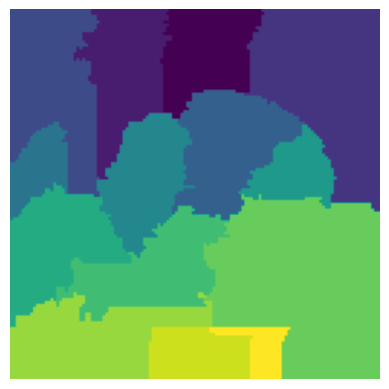

In [ ]:
plt.imshow(explanation.segments)
plt.axis('off')
plt.show()

In [ ]:
!pip install shap

In [ ]:
import shap

# Step 3: Initialize the Image masker
masker = shap.maskers.Image("input", shape=(128, 128, 3)) # Use "input" mode to mask the input image

def predict_fn(images):
    masks = model.predict(images)
    print(masks.shape)
    nsamples, nx, ny, nc = masks.shape
    return masks.reshape((nsamples,nx*ny*nc))

image = X_train[sample]
nx, ny, nc = image.shape
image= image.reshape((nx*ny*nc))
print(image.shape)
# Step 4: Generate SHAP values
explainer = shap.Explainer(model.predict, masker) # Create explainer object for your U-net model
shap_values = explainer(image) # Compute SHAP values for the input image

# Step 5: Visualize SHAP explanations
shap.summary_plot(shap_values, image) # Generate summary plot
for i in range(4):
    plt.figure()
    shap.image_plot(shap_values[i], image, show=False)
    plt.title(f'SHAP explanations for Class {i+1}')
    plt.show()


(32768,)


DimensionError: ignored

In [ ]:
from lime import lime_tabular

# Load the image data and flatten the pixel values for T1ce, T2, and FLAIR images
# Replace this with your own code to load and preprocess your image data
image_data = X_train[10]
t1ce_pixels = image_data[:, :, 0].flatten()
t2_pixels = image_data[:, :, 1].flatten()
flair_pixels = image_data[:, :, 2].flatten()

# Define the function to get predictions from the U-Net model
def predict_fn(X):
    print(X.shape)

    masks = model.predict(X)
    # Flatten the masks to get a 1D array of predicted probabilities
    return masks.reshape(-1, 4)

# Create a LimeTabularExplainer instance
explainer = lime_tabular.LimeTabularExplainer(X_train[10], 
                                               feature_names=['T1ce', 'T2', 'FLAIR'])

# Explain the U-Net model's predictions using LIME
# Note: You may need to adjust the settings, such as top_labels and num_samples, based on your specific use case
explanation = explainer.explain_instance(np.array([t1ce_pixels[0], t2_pixels[0], flair_pixels[0]]), 
                                         predict_fn, top_labels=1, num_samples=1000)

# Get the explanation's local feature importance scores
feature_importance = explanation.local_exp[0]

# The most important feature will be the one with the highest absolute local feature importance score
most_important_feature_idx = np.argmax(np.abs(feature_importance))
most_important_feature = explainer.feature_names[most_important_feature_idx]


IndexError: ignored

In [ ]:
import lime
from lime import lime_tabular

# Define your feature names here
feature_names = ['t1ce', 't2', 'flair']

# Define your class names here
class_names = list(SEGMENT_CLASSES.keys())


# Define your prediction function here
def predict_fn(x):
    return model.predict(x)

# Get a batch of data from your data generator
# X_train, y_train = training_gen.__getitem__(0)
for X_train, y_train in training_gen:
  # Convert the batch of data to a numpy array
  X_train_array = np.asarray(X_train)

  print(X_train_array.shape)
  explainer = lime.lime_tabular.LimeTabularExplainer(X_train_array, 
                                                   feature_names=feature_names, 
                                                   class_names=class_names, 
                                                   categorical_features=categorical_features, 
                                                   verbose=True, mode='regression')
  # Get the explanation for a test instance
  exp = explainer.explain_instance(X_train_array, predict_fn, num_features=len(feature_names))

  # Print the explanation
  exp.show_in_notebook(show_table=True)

In [ ]:
import lime
from lime import lime_image

# Instantiate the explainer
explainer = lime_image.LimeImageExplainer()

# Define a function that takes in a batch of data and returns the corresponding predictions
def predict_fn(data):
    # Reshape the data to have an additional dimension for the slices
    data = data.reshape((-1, num_slices, height, width, num_channels))
    # Swap the batch and slice dimensions
    data = data.swapaxes(0, 1)
    # Reshape the data back to 4D
    data = data.reshape((-1, height, width, num_channels))
    # Get the predictions for each slice
    predictions = model.predict(data)
    # Reshape the predictions to have an additional dimension for the slices
    predictions = predictions.reshape((num_slices, -1, num_classes))
    # Swap the batch and slice dimensions
    predictions = predictions.swapaxes(0, 1)
    # Reshape the predictions back to 2D
    predictions = predictions.reshape((-1, num_classes))
    return predictions

# Generate a batch of data using the data generator
data = next(data_generator)

# Generate explanations for each slice of the 3D image
explanations = []
for i in range(VOLUME_SLICES//5):
    # Get the ith slice of the 3D image
    slice_data = data[:, i]
    # Generate an explanation for the ith slice
    explanation = explainer.explain_instance(slice_data, predict_fn)
    explanations.append(explanation)